In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import arrow
from pathlib import Path
import netCDF4 as nc
from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean.cm as cm

In [23]:
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)
meshmask = xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
tmask = meshmask.tmask
mbathy = meshmask.mbathy
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc')

thalweg_SoG = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg = np.loadtxt(thalweg_SoG, delimiter=' ', dtype=int)
mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
depth = mesh.variables['gdept_0'][:]

In [24]:
jj_sog = grid_lons_lats.jj.sel(lats=49.039467, lons=-123.425033, method='nearest') # 305 m (Obs)
ii_sog = grid_lons_lats.ii.sel(lats=49.039467, lons=-123.425033, method='nearest')
print((jj_sog.item(),ii_sog.item()))

(423, 266)


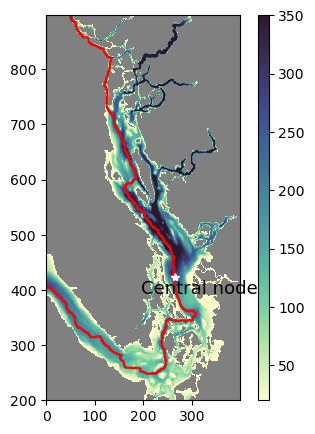

In [25]:
line, col = (1, 1)
fig, ax = plt.subplots(line, col, figsize=(10, 5))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.set_ylim([200, 898])
vmin,vmax=(20,350)
im = ax.pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=vmin, vmax=vmax)
ax.plot(thalweg[:,1],thalweg[:,0],color='r')
ax.plot(ii_sog, jj_sog,'w*') # Central node
ax.text(ii_sog-70, jj_sog-30,'Central node',fontsize=13)
viz_tools.set_aspect(ax);
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


#### oxygen budget - SBL/BBL at Central node

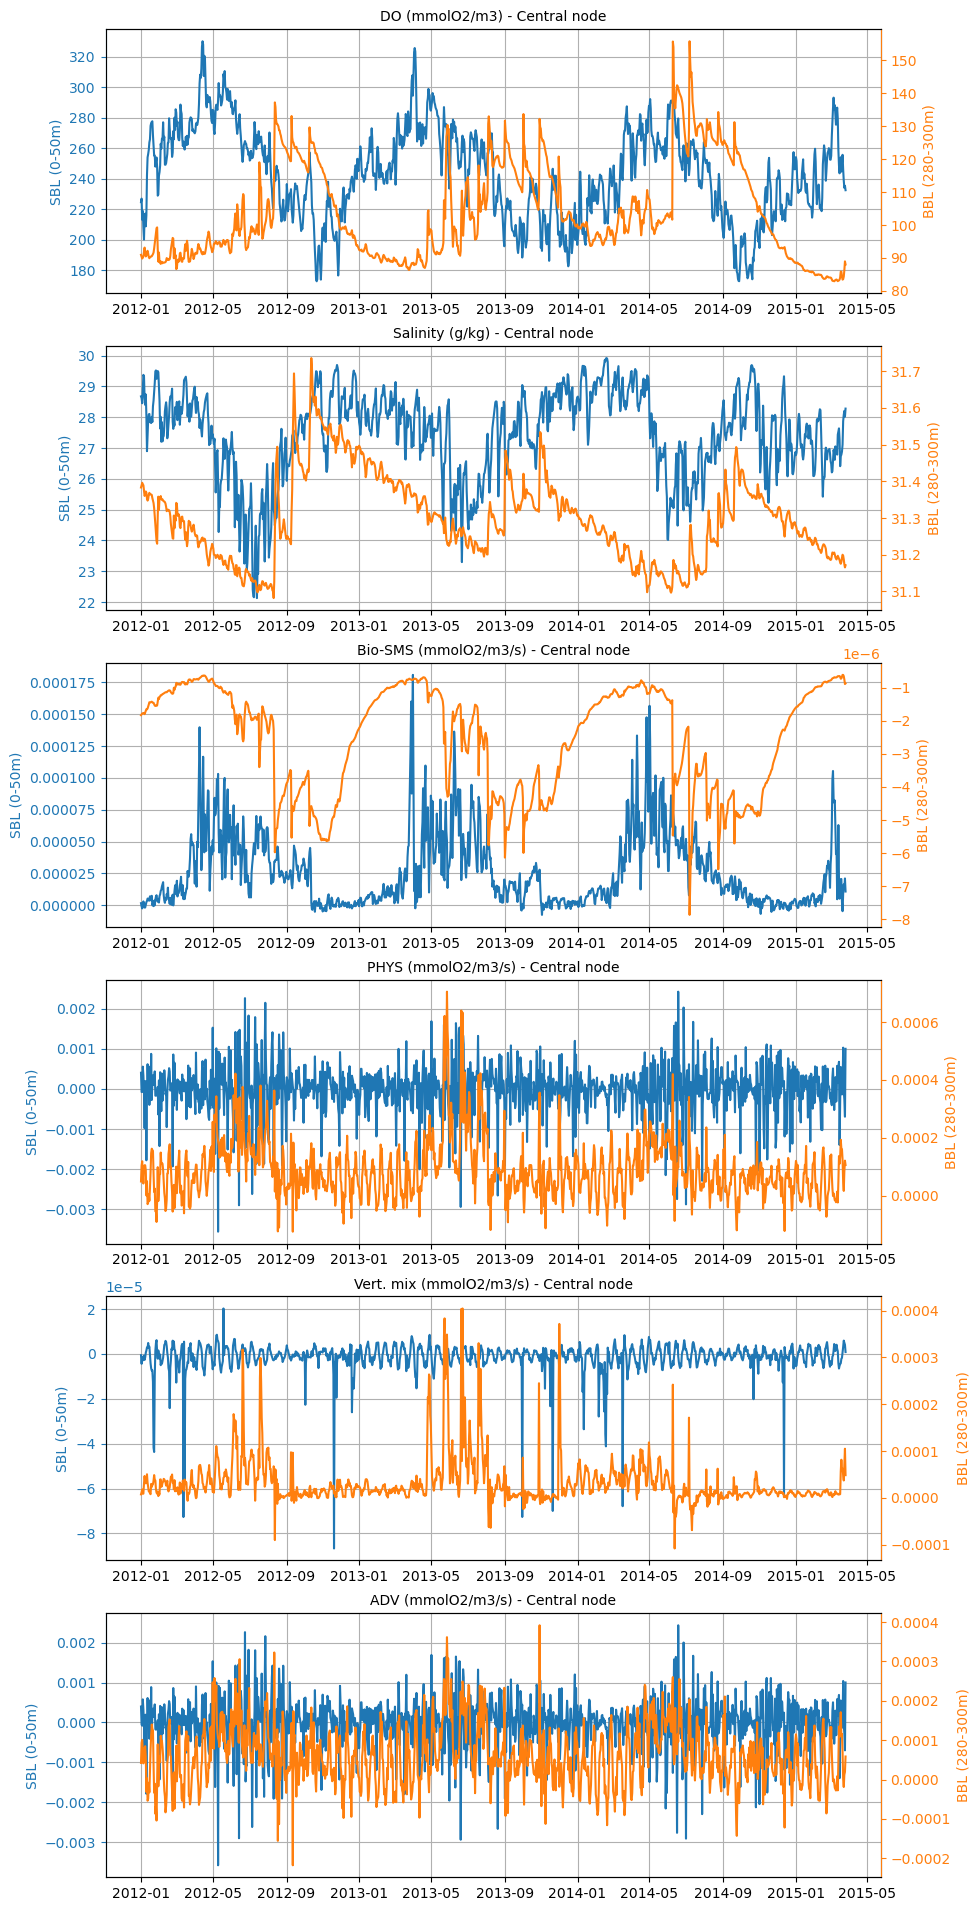

In [4]:
syear, smonth, sday = (2012, 1, 1)
eyear, emonth, eday = (2015, 3, 25)
#eyear, emonth, eday = (2018, 1, 10) #for test
startdate = arrow.get(syear, smonth, sday)
enddate = arrow.get(eyear, emonth, eday)
line, col = (6, 1)
title = list(['DO (mmolO2/m3)','Salinity (g/kg)','Bio-SMS (mmolO2/m3/s)','PHYS (mmolO2/m3/s)','Vert. mix (mmolO2/m3/s)','ADV (mmolO2/m3/s)'])
dir = '/ocean/sallen/timbucktwo/oxygen/'
fig, axs = plt.subplots(line, col, figsize=(10, 4*line))
#fig.suptitle('Central node',fontsize=18)
for ii in range(0, 2):
    if ii==0:
        K1, K2, JJ, II = (0, 24, jj_sog, ii_sog)
        
    else:
        K1, K2, JJ, II = (34, 35, jj_sog, ii_sog)       
        
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        fchem = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
        with xr.open_dataset(fchem) as ds_chem:
            oxy0 = ds_chem['dissolved_oxygen'][:,K1:K2,JJ,II].mean(axis=1)
        fgrdT = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
        with xr.open_dataset(fgrdT) as ds_grdT:
            sal0 = ds_grdT['vosaline'][:,K1:K2,JJ,II].mean(axis=1)
        fdiag = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_diag_T.nc'
        with xr.open_dataset(fdiag) as ds_diag:
            sms0 = ds_diag['SMS_O2'][:,K1:K2,JJ,II].mean(axis=1)
            phs0 = ds_diag['ZDF_O2'][:,K1:K2,JJ,II].mean(axis=1)+ds_diag['LDF_O2'][:,K1:K2,JJ,II].mean(axis=1)+ds_diag['TAD_O2'][:,K1:K2,JJ,II].mean(axis=1)
            tad0 = ds_diag['TAD_O2'][:,K1:K2,JJ,II].mean(axis=1)
            zdf0 = ds_diag['ZDF_O2'][:,K1:K2,JJ,II].mean(axis=1)
        if first:
            first = False
            oxy = oxy0
            sal = sal0
            sms = sms0
            phs = phs0
            tad = tad0
            zdf = zdf0
        else:
            oxy = xr.concat([oxy, oxy0], dim='time_counter')
            sal = xr.concat([sal, sal0], dim='time_counter')
            sms = xr.concat([sms, sms0], dim='time_counter')
            phs = xr.concat([phs, phs0], dim='time_counter')
            tad = xr.concat([tad, tad0], dim='time_counter')
            zdf = xr.concat([zdf, zdf0], dim='time_counter')
    for jj  in range(0, line):
        if jj==0:
            var=oxy
        elif jj==1:
            var=sal
        elif jj==2:
            var=sms
        elif jj==3:
            var=phs
        elif jj==4:
            var=zdf
        else:
            var=tad
            #axs[jj,ii].plot(tad.time_counter, tad, color='r');
        
        if ii==0:
            colors='C0'
            axs[jj].plot(var.time_counter, var, color=colors);
            axs[jj].tick_params(axis='y', color=colors, labelcolor=colors)
            axs[jj].set_ylabel('SBL (0-50m)', color=colors)
            axs[jj].spines['left'].set_color(colors)
            axs[jj].grid()
        else:
            colors='C1'
            axs2 = axs[jj].twinx()
            axs2.plot(var.time_counter, var, color=colors);
            axs2.tick_params(axis='y', color=colors, labelcolor=colors)
            axs2.spines['right'].set_color(colors)
            axs2.set_ylabel('BBL (280-300m)', color=colors)
        axs[jj].set_title(f'{title[jj]} - Central node',fontsize=10)
        


#### oxygen budget - along thalweg - 2012

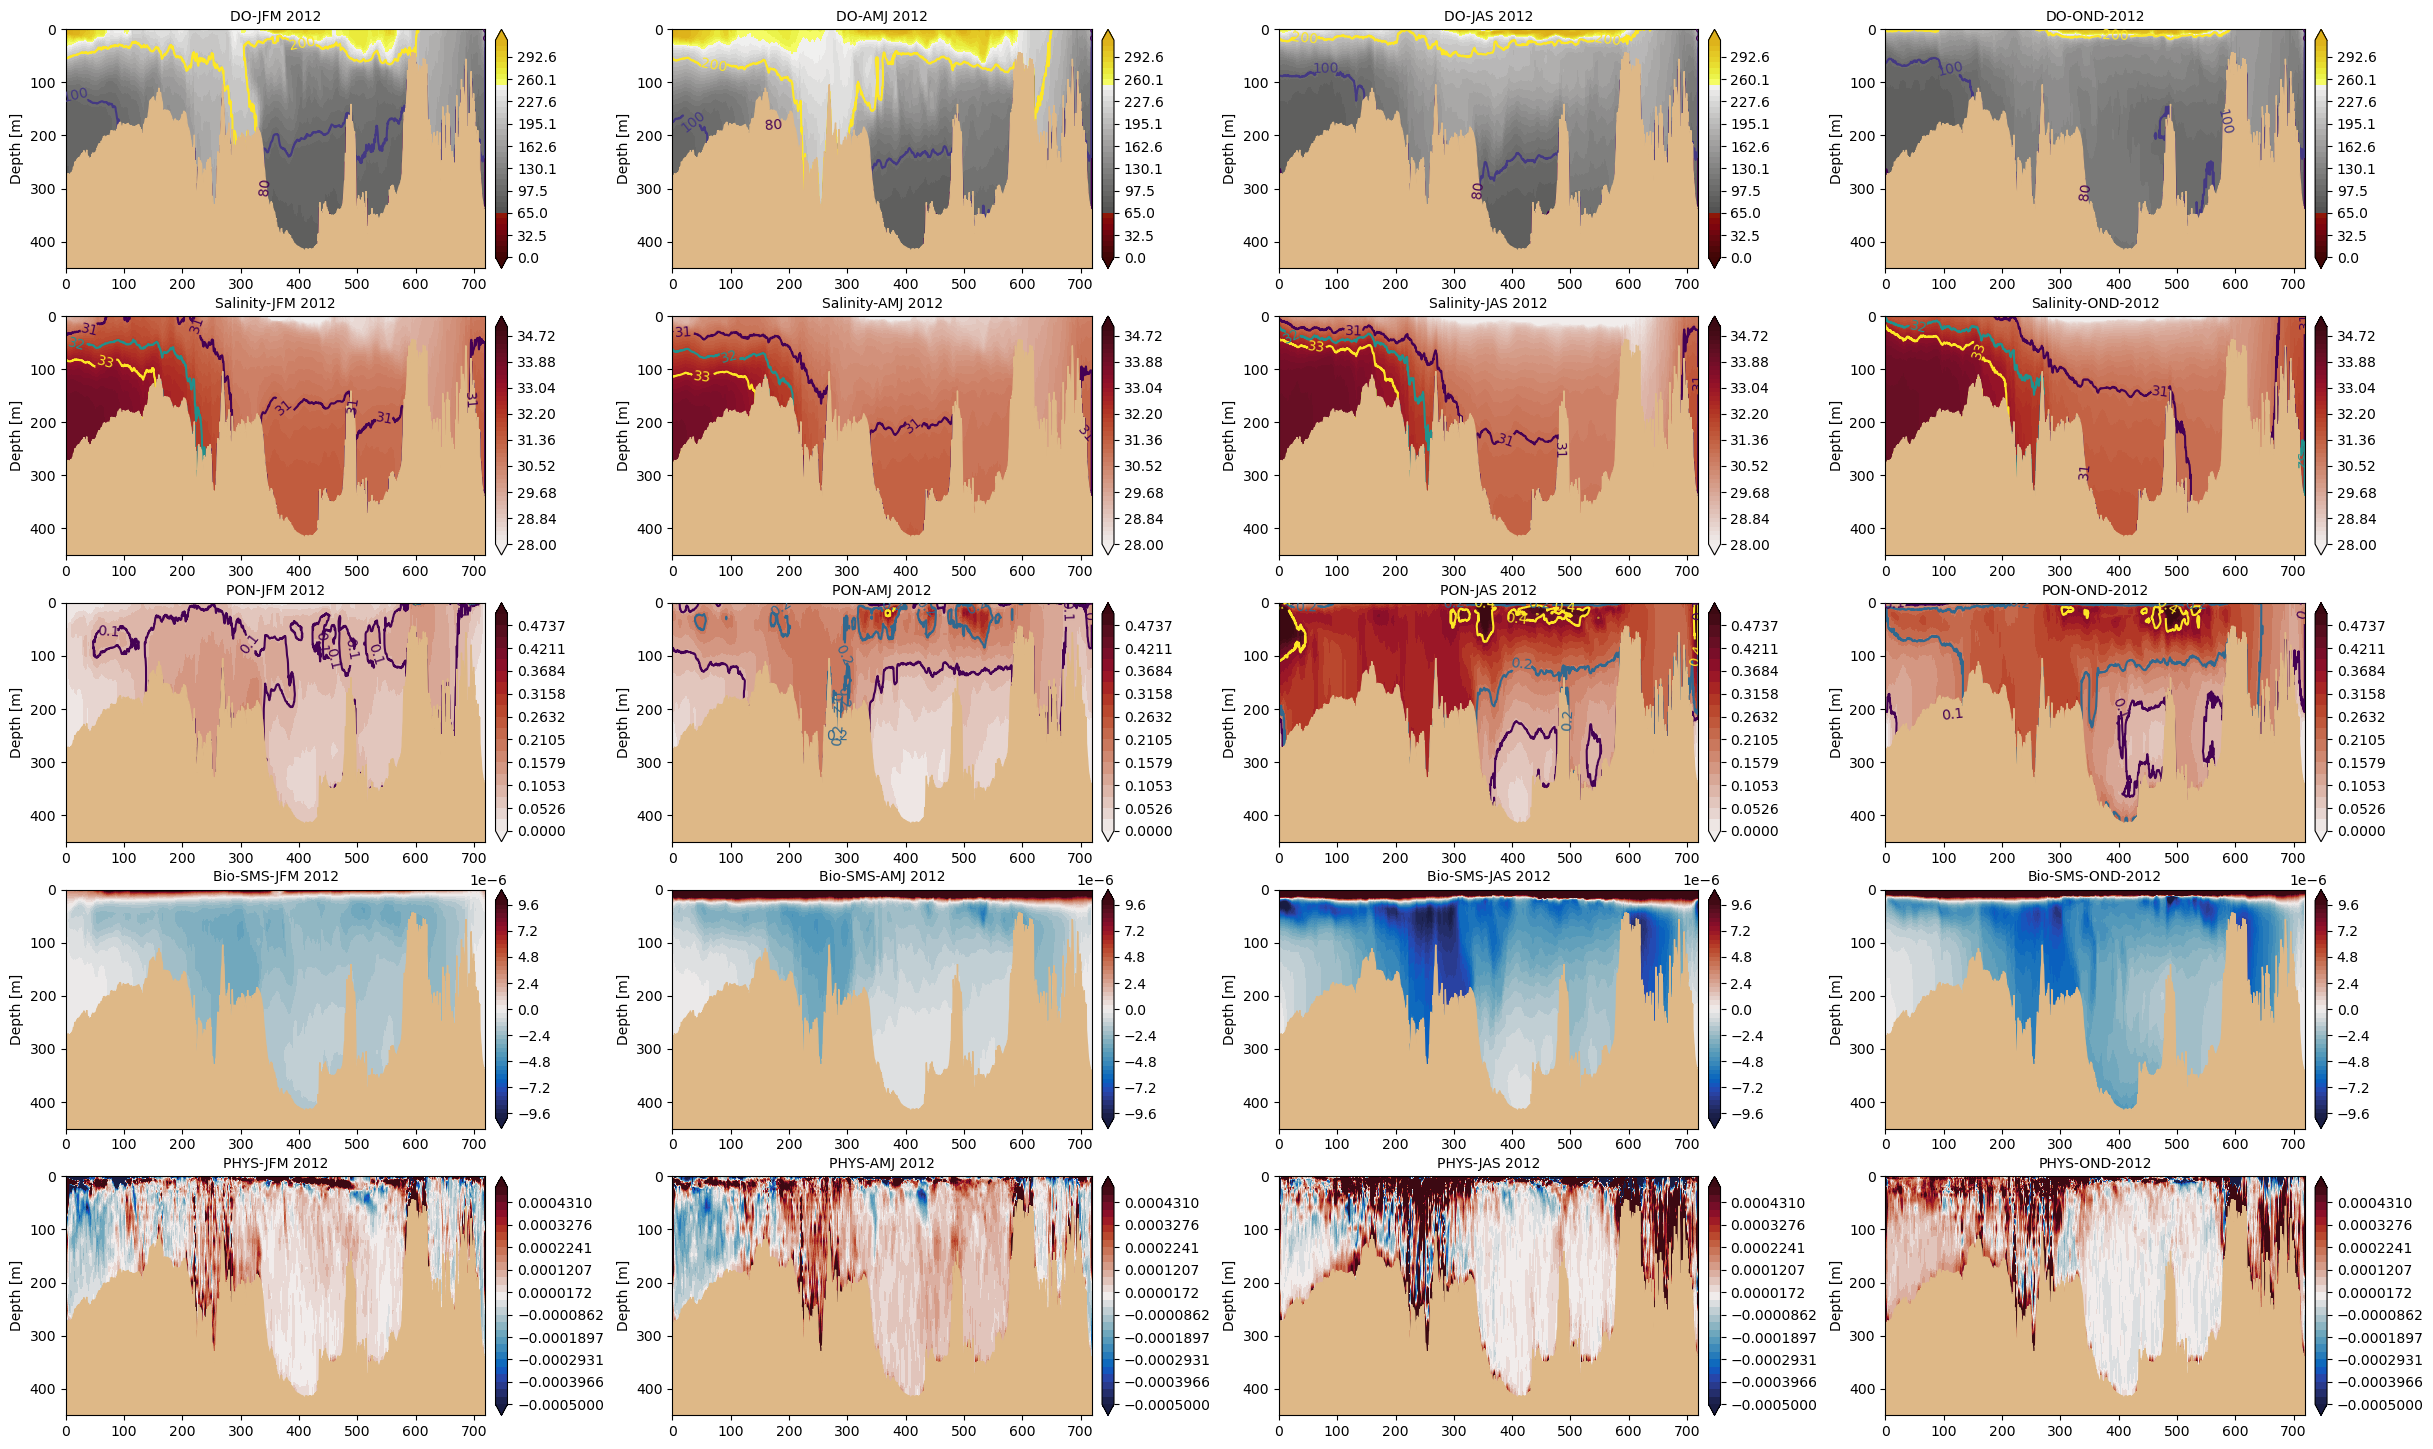

In [5]:
line, col = (5, 4)
fig, ax = plt.subplots(line, col, figsize=(30, 18))
# Compute timeseries along the thalwegs

dir = '/ocean/sallen/timbucktwo/oxygen/'
mmm = list(['JFM 2012','AMJ 2012','JAS 2012','OND-2012'])

for j in range(0, col): #change season
    if j==0:
        syear, smonth, sday = (2012, 1, 1)
        eyear, emonth, eday = (2012, 3, 31)
    elif j==1:
        syear, smonth, sday = (2012, 4, 1)
        eyear, emonth, eday = (2012, 6, 30)
    elif j==2:
        syear, smonth, sday = (2012, 7, 1)
        eyear, emonth, eday = (2012, 9, 30)
    else:
        syear, smonth, sday = (2012, 10, 1)
        eyear, emonth, eday = (2012, 12, 31)
    
    startdate = arrow.get(syear, smonth, sday)
    enddate = arrow.get(eyear, emonth, eday)
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        ds_chem = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc') 
        ds_biol = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc') 
        ds_diag = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_diag_T.nc') 
        ds_grdT = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc') 
        
        dep_thal, distance, oxy_thal = vis.load_thalweg(depth[0, ...], np.array(ds_chem.dissolved_oxygen).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, pon_thal = vis.load_thalweg(depth[0, ...], np.array(ds_biol.particulate_organic_nitrogen).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, sms_thal = vis.load_thalweg(depth[0, ...], np.array(ds_diag.SMS_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, phs_thal = vis.load_thalweg(depth[0, ...], np.array(ds_diag.LDF_O2+ds_diag.ZDF_O2+ds_diag.TAD_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, sal_thal = vis.load_thalweg(depth[0, ...], np.array(ds_grdT.vosaline).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        if first:
            first = False
            oxyTS = oxy_thal
            ponTS = pon_thal
            smsTS = sms_thal
            phsTS = phs_thal
            salTS = sal_thal
        else:
            oxyTS = np.vstack((oxyTS, oxy_thal))  
            ponTS = np.vstack((ponTS, pon_thal))
            smsTS = np.vstack((smsTS, sms_thal))  
            phsTS = np.vstack((phsTS, phs_thal)) 
            salTS = np.vstack((salTS, sal_thal))

    oxy = oxyTS.reshape(len(oxyTS)//len(ds_chem.dissolved_oxygen['deptht']),len(ds_chem.dissolved_oxygen['deptht']),len(thalweg))    
    pon = ponTS.reshape(len(ponTS)//len(ds_grdT.vosaline['deptht']),len(ds_grdT.vosaline['deptht']),len(thalweg)) 
    sms = smsTS.reshape(len(smsTS)//len(ds_chem.dissolved_oxygen['deptht']),len(ds_chem.dissolved_oxygen['deptht']),len(thalweg))    
    phs = phsTS.reshape(len(phsTS)//len(ds_chem.dissolved_oxygen['deptht']),len(ds_chem.dissolved_oxygen['deptht']),len(thalweg)) 
    sal = salTS.reshape(len(salTS)//len(ds_grdT.vosaline['deptht']),len(ds_grdT.vosaline['deptht']),len(thalweg)) 
    
    for i in range (0,line):
        if i==0:
            cmap=cm.oxy
            var = oxy
            space = np.linspace(0, 317, 40)
            cont = [80, 100, 200]
            title = 'DO'
        elif i==1:
            cmap = cm.amp
            var = sal
            space = np.linspace(28, 35, 51)
            cont = [31, 32, 33]
            title = 'Salinity'
        elif i==2:
            cmap = cm.amp
            var = pon
            space = np.linspace(0, 0.5, 20)
            cont = [0.1, 0.2, 0.4]
            title = 'PON'
        elif i==3:
            cmap = cm.balance
            var = sms
            space = np.linspace(-0.00001, 0.00001, 51)
            cont = [31, 33, 35]
            title = 'Bio-SMS'
        elif i==4:
            cmap = cm.balance
            var = phs
            space = np.linspace(-0.0005, 0.0005, 30)
            cont = [31, 33, 35]
            title = 'PHYS'

        var_plot = vis._fill_in_bathy(var[0,...], mesh, thalweg)
        colours_var = ax[i,j].contourf(distance, dep_thal, var_plot, space, cmap=cmap, extend='both')
        colourc_var = ax[i,j].contour(distance, dep_thal, var_plot, cont, zorder=1)
        ax[i,j].clabel(colourc_var, inline=True)
        vis._add_bathy_patch(distance, bathy['Bathymetry'][:], thalweg, ax[i,j], color='burlywood')
        ax[i,j].invert_yaxis()
        ax[i,j].set_ylabel('Depth [m]');
        ax[i,j].set_ylim([450, 0])
        ax[i,j].set_title(f'{title}-{mmm[j]}',fontsize=10)
        cbar = fig.colorbar(colours_var, ax=ax[i,j], pad=0.02)

#### oxygen budget - along thalweg - 2013

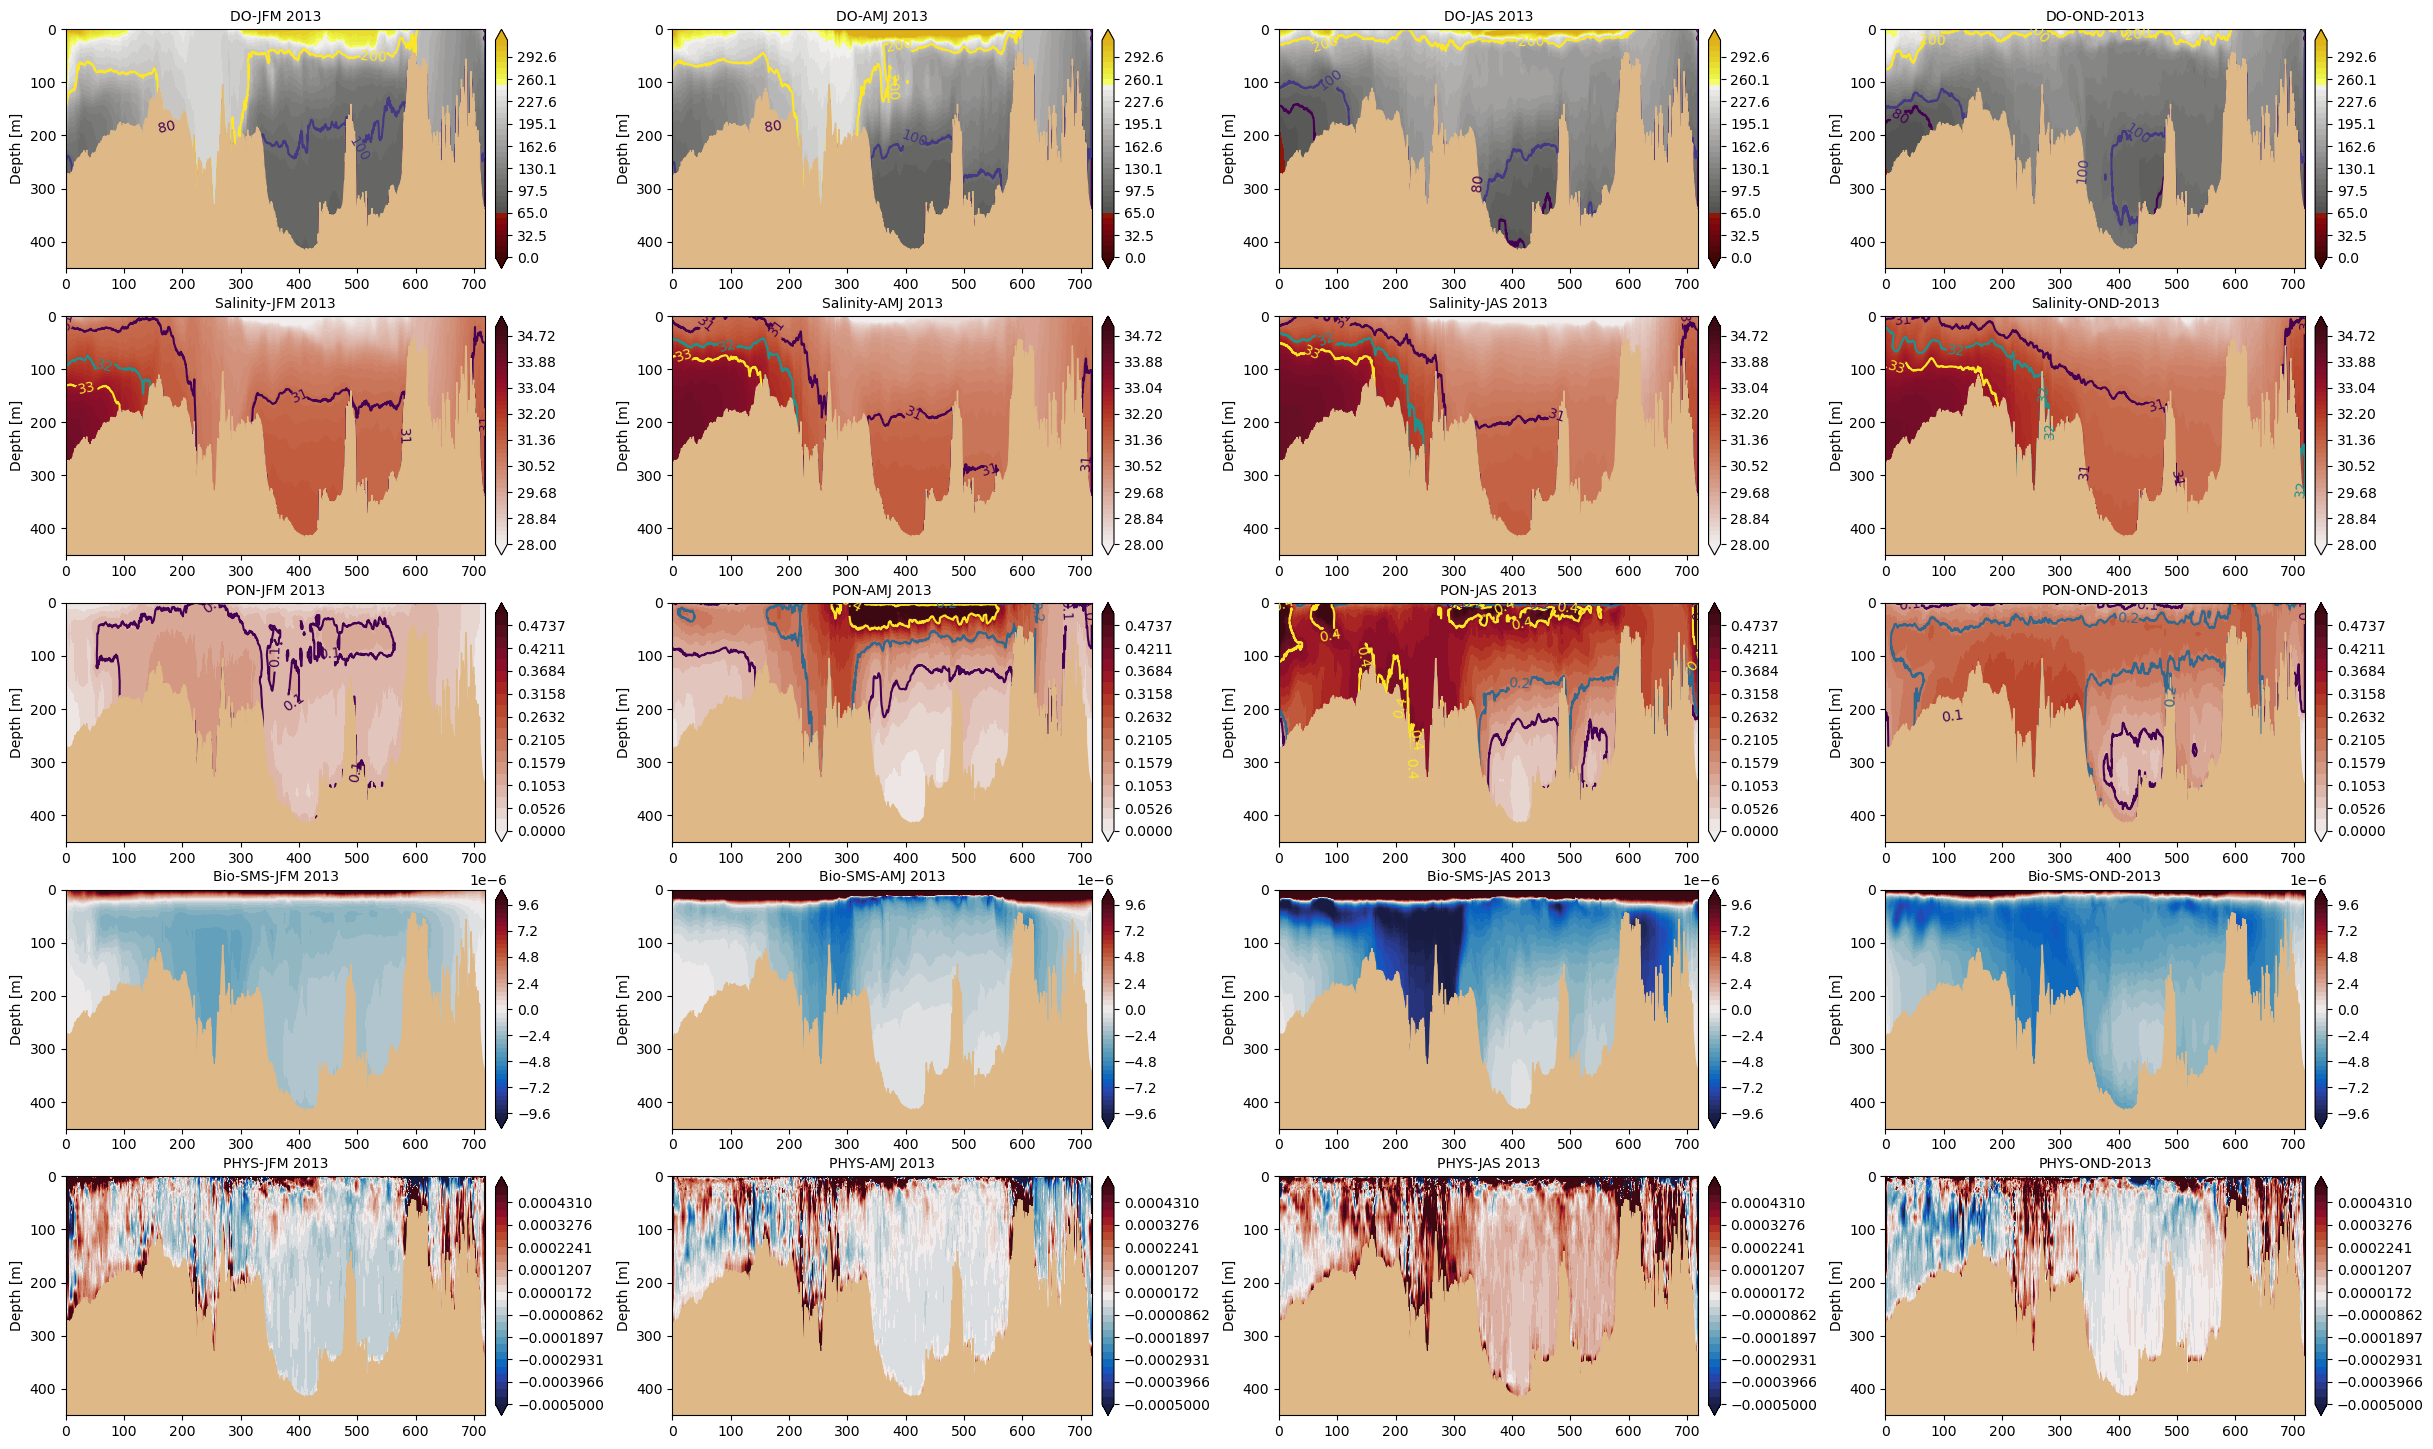

In [6]:
line, col = (5, 4)
fig, ax = plt.subplots(line, col, figsize=(30, 18))
# Compute timeseries along the thalwegs

dir = '/ocean/sallen/timbucktwo/oxygen/'
mmm = list(['JFM 2013','AMJ 2013','JAS 2013','OND-2013'])

for j in range(0, col): #change season
    if j==0:
        syear, smonth, sday = (2013, 1, 1)
        eyear, emonth, eday = (2013, 3, 31)
    elif j==1:
        syear, smonth, sday = (2013, 4, 1)
        eyear, emonth, eday = (2013, 6, 30)
    elif j==2:
        syear, smonth, sday = (2013, 7, 1)
        eyear, emonth, eday = (2013, 9, 30)
    else:
        syear, smonth, sday = (2013, 10, 1)
        eyear, emonth, eday = (2013, 12, 31)
    
    startdate = arrow.get(syear, smonth, sday)
    enddate = arrow.get(eyear, emonth, eday)
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        ds_chem = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc') 
        ds_biol = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc') 
        ds_diag = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_diag_T.nc') 
        ds_grdT = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc') 
        
        dep_thal, distance, oxy_thal = vis.load_thalweg(depth[0, ...], np.array(ds_chem.dissolved_oxygen).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, pon_thal = vis.load_thalweg(depth[0, ...], np.array(ds_biol.particulate_organic_nitrogen).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, sms_thal = vis.load_thalweg(depth[0, ...], np.array(ds_diag.SMS_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, phs_thal = vis.load_thalweg(depth[0, ...], np.array(ds_diag.LDF_O2+ds_diag.ZDF_O2+ds_diag.TAD_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, sal_thal = vis.load_thalweg(depth[0, ...], np.array(ds_grdT.vosaline).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        if first:
            first = False
            oxyTS = oxy_thal
            ponTS = pon_thal
            smsTS = sms_thal
            phsTS = phs_thal
            salTS = sal_thal
        else:
            oxyTS = np.vstack((oxyTS, oxy_thal))  
            ponTS = np.vstack((ponTS, pon_thal))
            smsTS = np.vstack((smsTS, sms_thal))  
            phsTS = np.vstack((phsTS, phs_thal)) 
            salTS = np.vstack((salTS, sal_thal))

    oxy = oxyTS.reshape(len(oxyTS)//len(ds_chem.dissolved_oxygen['deptht']),len(ds_chem.dissolved_oxygen['deptht']),len(thalweg))    
    pon = ponTS.reshape(len(ponTS)//len(ds_grdT.vosaline['deptht']),len(ds_grdT.vosaline['deptht']),len(thalweg)) 
    sms = smsTS.reshape(len(smsTS)//len(ds_chem.dissolved_oxygen['deptht']),len(ds_chem.dissolved_oxygen['deptht']),len(thalweg))    
    phs = phsTS.reshape(len(phsTS)//len(ds_chem.dissolved_oxygen['deptht']),len(ds_chem.dissolved_oxygen['deptht']),len(thalweg)) 
    sal = salTS.reshape(len(salTS)//len(ds_grdT.vosaline['deptht']),len(ds_grdT.vosaline['deptht']),len(thalweg)) 
    
    for i in range (0,line):
        if i==0:
            cmap=cm.oxy
            var = oxy
            space = np.linspace(0, 317, 40)
            cont = [80, 100, 200]
            title = 'DO'
        elif i==1:
            cmap = cm.amp
            var = sal
            space = np.linspace(28, 35, 51)
            cont = [31, 32, 33]
            title = 'Salinity'
        elif i==2:
            cmap = cm.amp
            var = pon
            space = np.linspace(0, 0.5, 20)
            cont = [0.1, 0.2, 0.4]
            title = 'PON'
        elif i==3:
            cmap = cm.balance
            var = sms
            space = np.linspace(-0.00001, 0.00001, 51)
            cont = [31, 33, 35]
            title = 'Bio-SMS'
        elif i==4:
            cmap = cm.balance
            var = phs
            space = np.linspace(-0.0005, 0.0005, 30)
            cont = [31, 33, 35]
            title = 'PHYS'

        var_plot = vis._fill_in_bathy(var[0,...], mesh, thalweg)
        colours_var = ax[i,j].contourf(distance, dep_thal, var_plot, space, cmap=cmap, extend='both')
        colourc_var = ax[i,j].contour(distance, dep_thal, var_plot, cont, zorder=1)
        ax[i,j].clabel(colourc_var, inline=True)
        vis._add_bathy_patch(distance, bathy['Bathymetry'][:], thalweg, ax[i,j], color='burlywood')
        ax[i,j].invert_yaxis()
        ax[i,j].set_ylabel('Depth [m]');
        ax[i,j].set_ylim([450, 0])
        ax[i,j].set_title(f'{title}-{mmm[j]}',fontsize=10)
        cbar = fig.colorbar(colours_var, ax=ax[i,j], pad=0.02)

#### oxygen budget - along thalweg - 2014

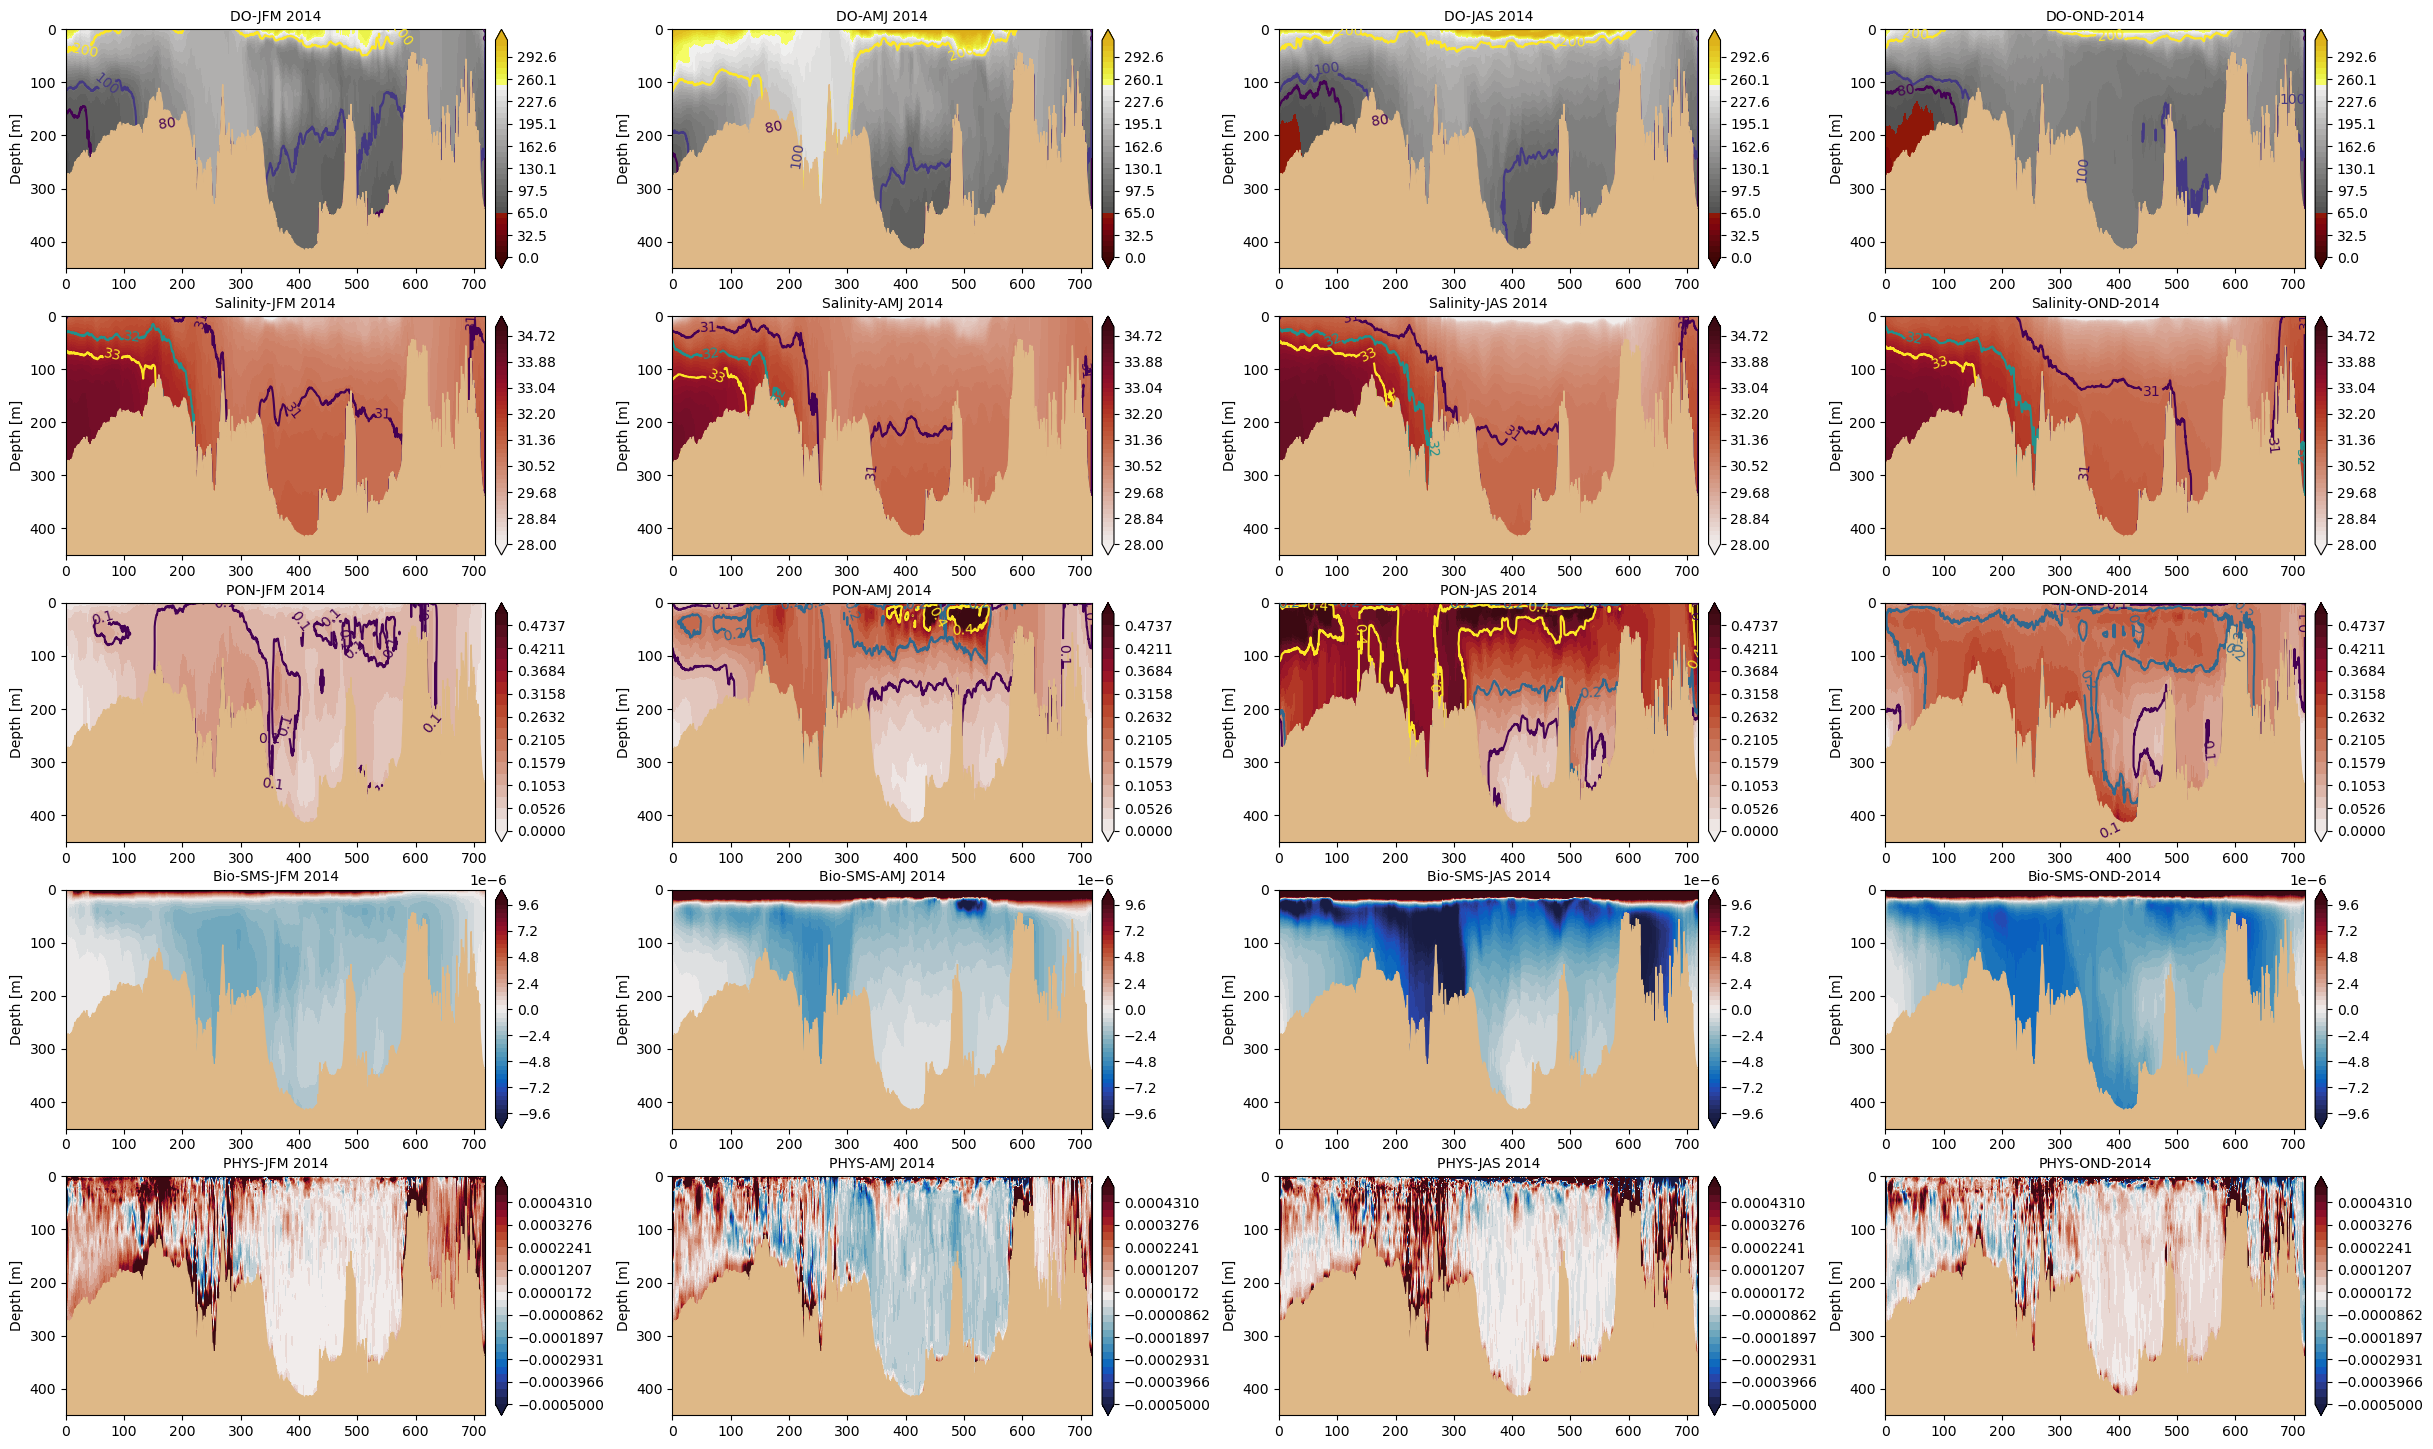

In [7]:
line, col = (5, 4)
fig, ax = plt.subplots(line, col, figsize=(30, 18))
# Compute timeseries along the thalwegs

dir = '/ocean/sallen/timbucktwo/oxygen/'
mmm = list(['JFM 2014','AMJ 2014','JAS 2014','OND-2014'])

for j in range(0, col): #change season
    if j==0:
        syear, smonth, sday = (2014, 1, 1)
        eyear, emonth, eday = (2014, 3, 31)
    elif j==1:
        syear, smonth, sday = (2014, 4, 1)
        eyear, emonth, eday = (2014, 6, 30)
    elif j==2:
        syear, smonth, sday = (2014, 7, 1)
        eyear, emonth, eday = (2014, 9, 30)
    else:
        syear, smonth, sday = (2014, 10, 1)
        eyear, emonth, eday = (2014, 12, 31)
    
    startdate = arrow.get(syear, smonth, sday)
    enddate = arrow.get(eyear, emonth, eday)
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        ds_chem = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc') 
        ds_biol = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc') 
        ds_diag = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_diag_T.nc') 
        ds_grdT = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc') 
        
        dep_thal, distance, oxy_thal = vis.load_thalweg(depth[0, ...], np.array(ds_chem.dissolved_oxygen).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, pon_thal = vis.load_thalweg(depth[0, ...], np.array(ds_biol.particulate_organic_nitrogen).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, sms_thal = vis.load_thalweg(depth[0, ...], np.array(ds_diag.SMS_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, phs_thal = vis.load_thalweg(depth[0, ...], np.array(ds_diag.LDF_O2+ds_diag.ZDF_O2+ds_diag.TAD_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        dep_thal, distance, sal_thal = vis.load_thalweg(depth[0, ...], np.array(ds_grdT.vosaline).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalweg)
        if first:
            first = False
            oxyTS = oxy_thal
            ponTS = pon_thal
            smsTS = sms_thal
            phsTS = phs_thal
            salTS = sal_thal
        else:
            oxyTS = np.vstack((oxyTS, oxy_thal))  
            ponTS = np.vstack((ponTS, pon_thal))
            smsTS = np.vstack((smsTS, sms_thal))  
            phsTS = np.vstack((phsTS, phs_thal)) 
            salTS = np.vstack((salTS, sal_thal))

    oxy = oxyTS.reshape(len(oxyTS)//len(ds_chem.dissolved_oxygen['deptht']),len(ds_chem.dissolved_oxygen['deptht']),len(thalweg))    
    pon = ponTS.reshape(len(ponTS)//len(ds_grdT.vosaline['deptht']),len(ds_grdT.vosaline['deptht']),len(thalweg)) 
    sms = smsTS.reshape(len(smsTS)//len(ds_chem.dissolved_oxygen['deptht']),len(ds_chem.dissolved_oxygen['deptht']),len(thalweg))    
    phs = phsTS.reshape(len(phsTS)//len(ds_chem.dissolved_oxygen['deptht']),len(ds_chem.dissolved_oxygen['deptht']),len(thalweg)) 
    sal = salTS.reshape(len(salTS)//len(ds_grdT.vosaline['deptht']),len(ds_grdT.vosaline['deptht']),len(thalweg)) 
    
    for i in range (0,line):
        if i==0:
            cmap=cm.oxy
            var = oxy
            space = np.linspace(0, 317, 40)
            cont = [80, 100, 200]
            title = 'DO'
        elif i==1:
            cmap = cm.amp
            var = sal
            space = np.linspace(28, 35, 51)
            cont = [31, 32, 33]
            title = 'Salinity'
        elif i==2:
            cmap = cm.amp
            var = pon
            space = np.linspace(0, 0.5, 20)
            cont = [0.1, 0.2, 0.4]
            title = 'PON'
        elif i==3:
            cmap = cm.balance
            var = sms
            space = np.linspace(-0.00001, 0.00001, 51)
            cont = [31, 33, 35]
            title = 'Bio-SMS'
        elif i==4:
            cmap = cm.balance
            var = phs
            space = np.linspace(-0.0005, 0.0005, 30)
            cont = [31, 33, 35]
            title = 'PHYS'

        var_plot = vis._fill_in_bathy(var[0,...], mesh, thalweg)
        colours_var = ax[i,j].contourf(distance, dep_thal, var_plot, space, cmap=cmap, extend='both')
        colourc_var = ax[i,j].contour(distance, dep_thal, var_plot, cont, zorder=1)
        ax[i,j].clabel(colourc_var, inline=True)
        vis._add_bathy_patch(distance, bathy['Bathymetry'][:], thalweg, ax[i,j], color='burlywood')
        ax[i,j].invert_yaxis()
        ax[i,j].set_ylabel('Depth [m]');
        ax[i,j].set_ylim([450, 0])
        ax[i,j].set_title(f'{title}-{mmm[j]}',fontsize=10)
        cbar = fig.colorbar(colours_var, ax=ax[i,j], pad=0.02)